## Import necessary libraries

In [1]:
# If you are in the Notebooks directory inside our project, no need run below line
!git clone https://github.com/ex3ploiter/DISTIL/

Cloning into 'DISTIL'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 790 (delta 200), reused 179 (delta 96), pack-reused 488 (from 1)
Receiving objects: 100% (790/790), 3.52 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (485/485), done.


In [2]:
# You should be in Notebooks directory
%cd "./DISTIL/DISTIL/Notebooks"

/kaggle/working/DISTIL/DISTIL/Notebooks


In [3]:
import sys
sys.path.append('../../../')

In [4]:
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-3_bv3_pi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-3_bv3_pi
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Created wheel 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

from DISTIL.DISTIL.models.diffusion_model import generate_image_with_classifier
from DISTIL.DISTIL.utils.model_utils import get_classifier_layer, trigger_evaluation, get_images_and_labels_by_label, greedy_class_farthest, plot_image_tensor
# from DISTIL.DISTIL.data_loader.model_loader import load_backdoored_models
from DISTIL.DISTIL.data_loader import  backbench
from DISTIL.DISTIL.detection.backdoor_target_detector import BackdoorTargetDetector

## Download GTSRB

In [6]:
%%capture
!chmod +x ../scripts/download_gtsrb.sh
!../scripts/download_gtsrb.sh

In [7]:
## Setup environment

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Download and Unzip models

In [9]:
# !pip install gdown

%cd ..
!mkdir data
%cd data

!gdown 1LaRuFQDtQiAjnwXe_evCCpio4AwkxLrk

import gdown
import zipfile
import os

# # Google Drive file URL
# file_url = 'https://drive.google.com/file/d/1LaRuFQDtQiAjnwXe_evCCpio4AwkxLrk/view?usp=sharing'  # Replace with your Google Drive file URL

# # The path where the file will be saved
output_path = './OneDrive_1_4-23-2025.zip'

# # Download the zip file
# gdown.download(file_url, output_path, quiet=False)

# Unzipping the file
unzip_dir = './OneDrive_1_4-23-2025'  # Folder to extract the contents into

# Make the output directory if it does not exist
if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)

# Extract the contents of the zip file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f'File downloaded and unzipped to: {unzip_dir}')

!rm -rf $output_path


def extract_zip_files(source_folder, destination_folder):
    # Create destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through each file in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith('.zip'):
            zip_path = os.path.join(source_folder, filename)
            print(f"zip_path: {zip_path}")
            # Create a folder name based on the zip file name (without extension)
            inner_folder_name = os.path.splitext(filename)[0]
            inner_folder_path = os.path.join(destination_folder, inner_folder_name)
            os.makedirs(inner_folder_path, exist_ok=True)

            # Extract the zip file contents into the inner folder
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(inner_folder_path)

            print(f"Extracted {filename} into {inner_folder_path}")


source_folder = "./OneDrive_1_4-23-2025"      # Replace with the path to your folder containing zip files
destination_folder = "./OneDrive_1_4-23-2025-extracted"  # Replace with the path where you want to store the extracted files
extract_zip_files(source_folder, destination_folder)

!rm -rf $source_folder

%cd ..
%cd Notebooks

/kaggle/working/DISTIL/DISTIL
mkdir: cannot create directory ‘data’: File exists
/kaggle/working/DISTIL/DISTIL/data
Downloading...
From (original): https://drive.google.com/uc?id=1LaRuFQDtQiAjnwXe_evCCpio4AwkxLrk
From (redirected): https://drive.google.com/uc?id=1LaRuFQDtQiAjnwXe_evCCpio4AwkxLrk&confirm=t&uuid=040dc5a3-b1f0-450b-b560-a924f48b32da
To: /kaggle/working/DISTIL/DISTIL/data/OneDrive_1_4-23-2025.zip
100%|██████████████████████████████████████| 3.19G/3.19G [01:49<00:00, 29.3MB/s]
File downloaded and unzipped to: ./OneDrive_1_4-23-2025
zip_path: ./OneDrive_1_4-23-2025/gtsrb_preactresnet18_badnet_0_1.zip
Extracted gtsrb_preactresnet18_badnet_0_1.zip into ./OneDrive_1_4-23-2025-extracted/gtsrb_preactresnet18_badnet_0_1
zip_path: ./OneDrive_1_4-23-2025/gtsrb_preactresnet18_trojannn_0_1.zip
Extracted gtsrb_preactresnet18_trojannn_0_1.zip into ./OneDrive_1_4-23-2025-extracted/gtsrb_preactresnet18_trojannn_0_1
zip_path: ./OneDrive_1_4-23-2025/gtsrb_preactresnet18_wanet_0_1.zip
Extrac

## Configuration

In [10]:
MODEL_DIR = "../data/OneDrive_1_4-23-2025-extracted"
MODEL_ARCH = "vgg19"
DATASET = "cifar10"
LIMIT = 10
SEARCH_ALL_CLASSES = False
OUTPUT_FILE = "backdoor_target_class_prediction_results.txt"

## Run target class prediction on models
We calculate a score for each class (as the target class) and a source class (we use a heuristic to select this source class; for more info, check our paper. After calculating the score, we predict the class that has the highest corresponding score as the attack target class.
In this notebook, we only plot the first 4 classes to avoid a long output.

In [11]:
backdoor_models = backbench.BackbenchDataset(MODEL_DIR,model_name=None)

In [12]:
MODEL_DIR,DATASET,

('../data/OneDrive_1_4-23-2025-extracted', 'cifar10')

Selected models:
gtsrb_convnext_tiny_wanet_0_1
gtsrb_preactresnet18_badnet_0_1
gtsrb_preactresnet18_lira_0_1





Detecting backdoor targets:   0%|          | 0/3 [00:00<?, ?it/s]


Analyzing model: gtsrb_convnext_tiny_wanet_0_1
Model name: gtsrb_convnext_tiny_wanet_0_1
Examining 43 potential target classes


  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

/usr/local/lib/python3.11/dist-packages/glide_text2im/download.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(path, map_location=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 0, Source class: 24


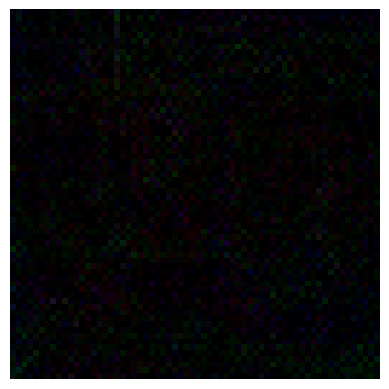

Trigger confidence: 0.7918082475662231


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 1, Source class: 20


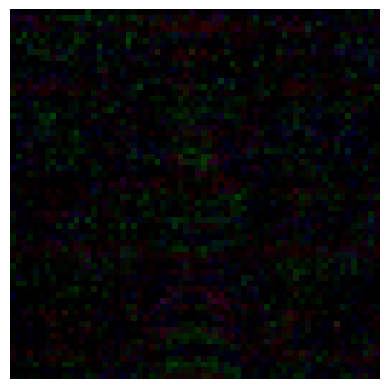

Trigger confidence: 0.0013311885995790362


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 2, Source class: 19


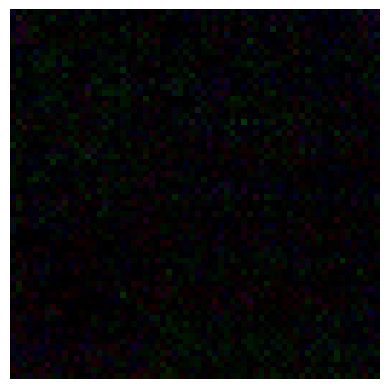

Trigger confidence: 0.0015407585306093097


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 3, Source class: 26


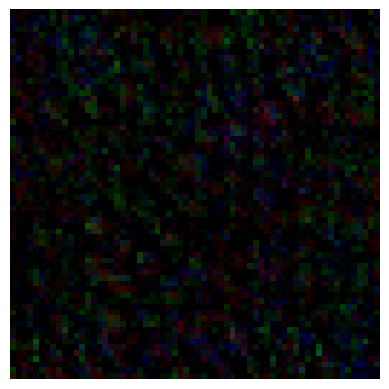

Trigger confidence: 0.00483333133161068


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Detecting backdoor targets:  33%|███▎      | 1/3 [27:21<54:42, 1641.24s/it]

model_name: gtsrb_convnext_tiny_wanet_0_1, predicted_target_class: 0, max_score: 0.8909117579460144, scores: [0.8909117579460144, 0.0008810980361886322, 0.00047313401591964066, 0.0028277093078941107, 9.943202167050913e-05, 0.01330954022705555, 0.0008232268737629056, 0.0006485766498371959, 0.0011410892475396395, 7.684739102842286e-05, 0.0012156286975368857, 0.0020492631010711193, 0.016748633235692978, 0.0217084139585495, 0.005316713359206915, 0.0057776193134486675, 0.00028861561440862715, 0.023250248283147812, 0.005065894685685635, 0.00032785371877253056, 0.0034877415746450424, 0.00010981818195432425, 0.0007819641032256186, 0.00015210339915938675, 0.00010993016621796414, 0.019492099061608315, 0.0014311963459476829, 0.0004306256305426359, 0.0013668282190337777, 0.0049050734378397465, 0.004007027484476566, 0.0011067555751651525, 0.0005338241462595761, 0.0002535590610932559, 0.0010215057991445065, 0.0018799278186634183, 0.0026181433349847794, 0.0011893161572515965, 0.005193657707422972, 0.

  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 0, Source class: 19


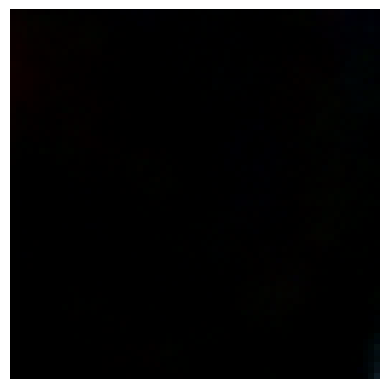

Trigger confidence: 0.9981655478477478


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 1, Source class: 31


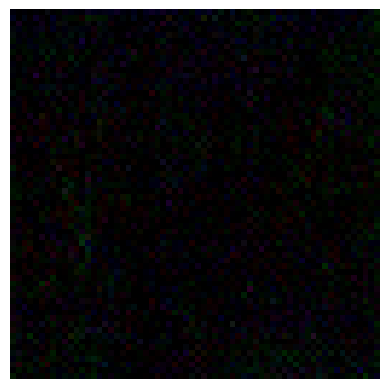

Trigger confidence: 4.856779924011789e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 2, Source class: 25


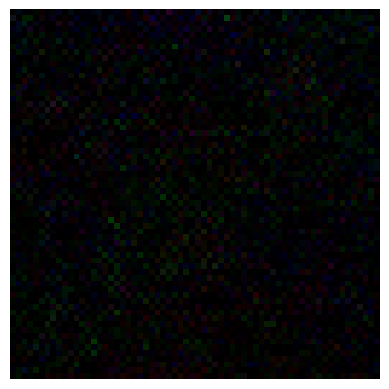

Trigger confidence: 8.844310650601983e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 3, Source class: 39


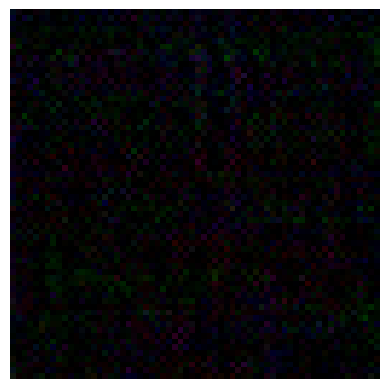

Trigger confidence: 4.251244172337465e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Detecting backdoor targets:  67%|██████▋   | 2/3 [40:56<19:15, 1155.57s/it]

model_name: gtsrb_preactresnet18_badnet_0_1, predicted_target_class: 0, max_score: 0.9644279479980469, scores: [0.9644279479980469, 0.0002956371463369578, 0.0033463456202298403, 0.0001607978338142857, 0.0014191465452313423, 0.00014167973131407052, 0.0002632914111018181, 0.00013912499707657844, 0.004139047581702471, 0.0007742203888483346, 0.00040013628313317895, 0.0005242425249889493, 0.0005097253597341478, 0.009615492075681686, 0.00045616927673108876, 0.0004496244073379785, 0.00016105128452181816, 0.0003026608028449118, 0.0001643472205614671, 6.58641365589574e-05, 0.0008435779018327594, 3.577001189114526e-05, 6.978214514674619e-05, 4.320251173339784e-05, 4.74309672426898e-05, 0.00019813785911537707, 3.712927718879655e-05, 8.293004066217691e-05, 9.50083922361955e-05, 4.391269612824544e-05, 0.00012949248775839806, 0.00023271712416317314, 0.0002613760298117995, 0.00028329991619102657, 0.007884521037340164, 0.0003079296147916466, 0.0007426411029882729, 9.369291365146637e-05, 0.001044052769

  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 0, Source class: 20


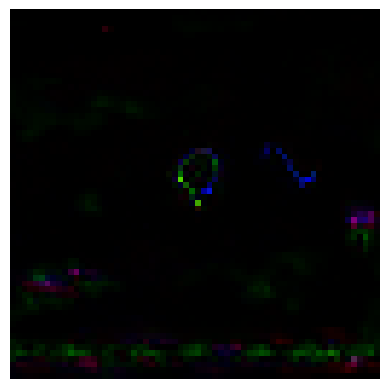

Trigger confidence: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 1, Source class: 17


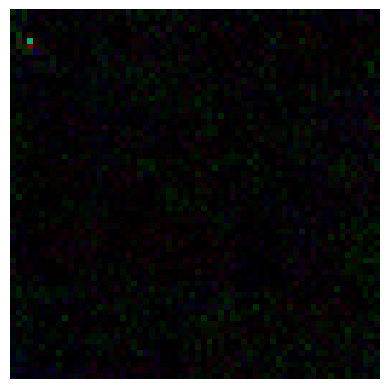

Trigger confidence: 2.544514043911761e-10


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 2, Source class: 17


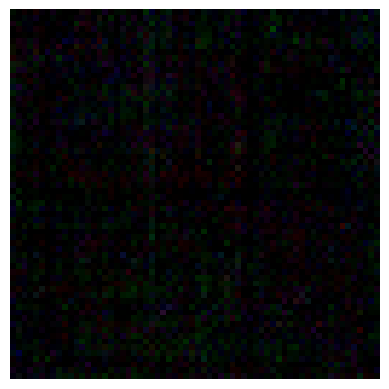

Trigger confidence: 4.036568388571249e-12


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 3, Source class: 27


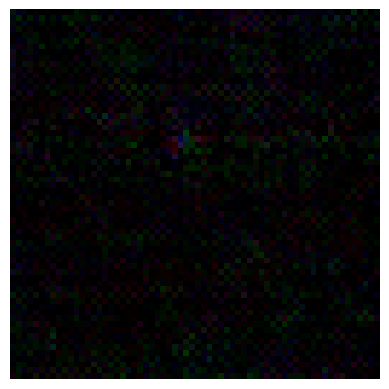

Trigger confidence: 5.5208428106912066e-11


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Detecting backdoor targets: 100%|██████████| 3/3 [54:33<00:00, 1091.24s/it]

model_name: gtsrb_preactresnet18_lira_0_1, predicted_target_class: 0, max_score: 1.0, scores: [1.0, 3.528283443188229e-08, 1.4416545290885097e-08, 1.7286277298467212e-08, 5.411458607607056e-12, 7.37398053729521e-08, 6.037189592689174e-08, 9.423066710603778e-13, 6.829661836071921e-10, 8.562164310887965e-08, 1.0663737688015873e-12, 3.003716742000506e-08, 4.675254072772361e-10, 4.010395140974232e-11, 9.547429726808332e-07, 2.0351579796407115e-11, 7.955936780490447e-07, 1.9450592247949317e-09, 2.9689718565595324e-12, 1.503056679119652e-09, 6.586907375094597e-07, 1.6084263920745911e-09, 6.763885979088613e-11, 1.6659258417206502e-09, 3.922243195120245e-06, 3.1753490929986583e-06, 7.209197683266666e-09, 5.240764977543222e-08, 1.7251370110216158e-08, 8.836897684959266e-13, 9.303356307555077e-08, 6.4544324746007575e-12, 6.048674663361453e-07, 7.931814138828486e-07, 5.6280972937639007e-11, 6.033335497868109e-10, 4.5555063193924994e-11, 1.3140780765752424e-06, 8.902859605086633e-08, 1.40287529575

In [13]:
# We just print triggers for first 4 classes to avoid long output in the notebook.

results = []
number_of_models = 0
number_of_correct_target_class_prediction = 0

number_of_models_to_be_tested = 3

selected_backdoor_models = [backdoor_models[i] for i in [5, 6, 10]]

print("Selected models:")
for model_data in selected_backdoor_models:
    print(model_data["model_name"])

print("\n\n")

for model_data in tqdm(selected_backdoor_models, desc="Detecting backdoor targets"):
    number_of_models += 1

    model_name = model_data["model_name"]

    ground_truth_target_class = 0 # target class of all backdoorbench models are 0
    print(f"\nAnalyzing model: {model_name}")

    try:
        # Detect target class
        predicted_target, scores, trigger = BackdoorTargetDetector(output_file=OUTPUT_FILE).detect_target_class(
            model_data,
        )

        # Print results
        print(f"Model: {model_name}")
        print(f"Predicted target class: {predicted_target}")
        print(f"Confidence scores: {scores}")

        if predicted_target == ground_truth_target_class:
            number_of_correct_target_class_prediction += 1

        results.append({
            "model_name": model_name,
            "predicted_target": predicted_target,
            "scores": scores
        })

    except Exception as e:
        print(f"Error analyzing model {model_name}: {e}")

print(f"\nDetection completed. Results saved to {OUTPUT_FILE}")
print(f"\nNumber of correct target class prediction: {number_of_correct_target_class_prediction}, Total models analyzed: {len(results)}")
